<center>
    <b>
        <span style="font-size:24px;">FINA 4335 - Computational Methods and Their Applications <span style="color:red;">in Finance</span></span>
    </b>
</center>
<center><span style="font-size:22px;"><b>Homework Assignment 4 <b></span></center>
<center><span style="font-size:22px;"><b>Due date: 11/26/2024 11:59 ET</b></span></center>  

## Instructions

1. Please rename the notebook. It should have the following format: **HW4_LastName_FirstName**, where LastName and FirstName are your last name and first name, respectively.
1. Please enter your first name, your last name, and your student id number in the dedicated cell.
1. Use your code or function on a variety of inputs to test that it works like you'd like it to. For example, you may print part of the data
1. Write your code in the specific cells.
1. After you answer all questions:
    1. Restart your kernel and run all cells
    1. Save your notebook and export your notebook as HTML
    1. Submit your **notebook** and **HTML** to Canvas, under Homework Assignments --> HW4.
       1. Failure to submit the HTML file  (with all outputs) will result in up to <span style="color: red;">20% grade deduction</span>.

**Note**:
- Name the variables exactly as requested. Python is **case-sensitive**, so `df` and `DF` are different variables
- Always **use code rather than eyeballing or manual calculations** to answer questions
- Write your code in a **smart and efficient** way
  - Inefficient code (including repetitive code) will be subject to grade deduction
- Include sufficient **comments** on your code
  - Failure to include sufficient comments will result in a 10 points grade deduction
- You may **restart kernel and clear output** occasionally to prevent unexpected results
- Use the methods **covered in modules 1-12**; </span>. Using formulas inconsistent to the lecture notebooks receives <span style="color: red;">20% of grade penalty</span>
- For conceptual questions, your answer must be related to code results and need to be **very specific** and clearly separate different points. You should not blend different points together

## Please enter your information here:
##### First Name: Simrin
##### Last Name: Ramchandani
##### Student ID Number: 001506072

In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import yfinance as yf
import scipy.stats as stats 
import statsmodels.api as sm
import pandas_datareader.data as web
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
print('My yfinance version is',yf.__version__)
print('My pandas version is',pd.__version__)
print('My numpy version is',np.__version__)

My yfinance version is 0.2.46
My pandas version is 2.2.2
My numpy version is 1.26.4


### Building a reversal factor

#### Question 1 (10 points)
Read the csv `monthly_returns_HW4.csv` to a DataFrame called `stock_returns`. Parse the column 'DATE' to `datetime` format. 
Next, sort `stock_returns` by 'PERMNO' and 'DATE'.

In [3]:
# Read the CSV data into a DataFrame
stock_returns = pd.read_csv('monthly_returns_HW4.csv')

# Convert the 'DATE' column to a datetime object
stock_returns['DATE'] = pd.to_datetime(stock_returns['DATE'], format='%Y%m%d')

# Sort dataframe
stock_returns.sort_values(['PERMNO', 'DATE'], inplace=True)


In [4]:
# Evaluation cell (do not change)
print(stock_returns.head())
stock_returns.info()

        DATE  PERMNO       PRC       RET
0 2014-01-31   10001   9.16083  0.147424
1 2014-02-28   10001   9.35064  0.025601
2 2014-03-31   10001  10.04994  0.079514
3 2014-04-30   10001  10.88910  0.087884
4 2014-05-30   10001  10.47951 -0.033453
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 321105 entries, 0 to 321104
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   DATE    321105 non-null  datetime64[ns]
 1   PERMNO  321105 non-null  int64         
 2   PRC     319732 non-null  float64       
 3   RET     319720 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 9.8 MB


#### Question 2 (10 points)
In `stock_returns`, drop rows if a stock's unadjusted price (`PRC`) at month t-1 is less or equal to $5. This step removes penny stocks that are illiquid.

In [5]:
# Add a new column for the previous month's price (PRC at t-1)
stock_returns['PRC_t_minus_1'] = stock_returns.groupby('PERMNO')['PRC'].shift(1)

# Filter rows where PRC at t-1 is greater than $5
stock_returns = stock_returns[stock_returns['PRC_t_minus_1'] > 5]

# Drop helper column
stock_returns = stock_returns.drop(columns=['PRC_t_minus_1'])

In [6]:
# Evaluation cell (do not change)
stock_returns.describe()
print(stock_returns)

             DATE  PERMNO        PRC       RET
1      2014-02-28   10001    9.35064  0.025601
2      2014-03-31   10001   10.04994  0.079514
3      2014-04-30   10001   10.88910  0.087884
4      2014-05-30   10001   10.47951 -0.033453
5      2014-06-30   10001   10.52946  0.009047
...           ...     ...        ...       ...
321100 2023-08-31   93436  257.82191 -0.034927
321101 2023-09-29   93436  249.96978 -0.030426
321102 2023-10-31   93436  200.63916 -0.197149
321103 2023-11-30   93436  239.83992  0.195184
321104 2023-12-29   93436  248.23152  0.034953

[244545 rows x 4 columns]


#### Question 3 (10 points)
Add one column to `stock_returns`:

- `reversal`:  a stock's return on month $t-1$. This variable measures a stock's short-term reversal.
  
  - According to Quantpedia, [the short-term reversal anomaly, the phenomenon that stocks with relatively low returns over the past month or week earn positive abnormal returns in the following month or week, and stocks with high returns earn negative abnormal returns, is well-researched.](https://quantpedia.com/strategies/short-term-reversal-in-stocks/)

In [7]:
# Add a 'reversal' column
stock_returns['reversal'] = stock_returns.groupby('PERMNO')['RET'].shift(1)
# stock_returns.head()

In [8]:
# Evaluation cell (do not change)
one_stock=stock_returns['PERMNO'].unique()[2]
print(stock_returns.loc[stock_returns['PERMNO']==one_stock,['DATE','PERMNO','RET','reversal']].head(8))

         DATE  PERMNO       RET  reversal
82 2014-02-28   10026  0.054203       NaN
83 2014-03-31   10026  0.036677  0.054203
84 2014-04-30   10026 -0.024670  0.036677
85 2014-05-30   10026  0.000747 -0.024670
86 2014-06-30   10026  0.008212  0.000747
87 2014-07-31   10026 -0.042775  0.008212
88 2014-08-29   10026  0.051231 -0.042775
89 2014-09-30   10026 -0.008755  0.051231


#### Question 4 (15 points)
Each month, assign stocks to 5 buckets (quintiles) based on their short-term reversal. The newly assigned column should be called `bucket_reversal`.
- Hint: To accomplish this, first create a separate DataFrame that excludes rows with missing values in `reversal`. Use this filtered DataFrame to generate `bucket_reversal`, then merge it back with the original `stock_returns` DataFrame. This method preserves all original variables in `stock_returns` while creating `bucket_reversal`.

In [9]:
# Exclude rows with missing values in the 'reversal' column
reversal_filtered = stock_returns.dropna(subset=['reversal'])

# Assign stocks to 5 buckets (quintiles) based on 'reversal'
reversal_filtered['bucket_reversal'] = (
    reversal_filtered.groupby('DATE', group_keys=False)['reversal']
    .apply(pd.qcut, q=5, labels=np.arange(1, 6))
)

# Convert the bucket to integer
reversal_filtered['bucket_reversal'] = reversal_filtered['bucket_reversal'].astype(int)

# Merge the bucket_reversal back into the original stock_returns
stock_returns = stock_returns.merge(
    reversal_filtered[['DATE', 'PERMNO', 'bucket_reversal']],
    on=['DATE', 'PERMNO'],
    how='left'
)


C:\Users\simri\AppData\Local\Temp\ipykernel_24656\3324987460.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reversal_filtered['bucket_reversal'] = (
C:\Users\simri\AppData\Local\Temp\ipykernel_24656\3324987460.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reversal_filtered['bucket_reversal'] = reversal_filtered['bucket_reversal'].astype(int)


In [10]:
# Evaluation cell (do not change)
stock_returns.loc[:,['DATE','PERMNO','RET','reversal', 'bucket_reversal']].head(8)

,DATE,PERMNO,RET,reversal,bucket_reversal
0,2014-02-28,10001,0.025601,NaN,NaN
1,2014-03-31,10001,0.079514,0.025601,2.0
2,2014-04-30,10001,0.087884,0.079514,5.0
3,2014-05-30,10001,-0.033453,0.087884,5.0
4,2014-06-30,10001,0.009047,-0.033453,2.0
5,2014-07-31,10001,0.227003,0.009047,2.0
6,2014-08-29,10001,-0.121291,0.227003,5.0
7,2014-09-30,10001,0.050924,-0.121291,1.0


#### Question 5 (15 points)
Create equally-weighted quintile portfolios for each month. The final portfolios should be stored in a DataFrame called `portfolios`. It should be indexed by `DATE` and the column names are  `reversal_1`to`reversal_5`, where `reversal_1` is the portfolio with the smallest reversal.

- Partial hint: You may generate the average returns by `bucket_reversal` and `DATE` first, then reshape the average returns from long to wide. Next, you rename the wide DataFrame.

In [11]:
# Group by 'DATE' and 'bucket_reversal' and calculate the mean return for each portfolio 

equal_weighted_returns = (
    reversal_filtered[['DATE', 'reversal', 'bucket_reversal']]  # Select relevant columns
    .groupby(['DATE', 'bucket_reversal'])  # Group by DATE and quintile bucket
    .mean()  # Calculate the mean return for each group
    .unstack()  # Pivot from long to wide format: DATE as index, 'bucket_reversal' as columns
)

# Rename the columns 
equal_weighted_returns.columns = ['reversal_1', 'reversal_2', 'reversal_3', 'reversal_4', 'reversal_5']

# Store result in 'portfolios' DataFrame
portfolios = equal_weighted_returns


In [12]:
# Evaluation cell (do not change)
portfolios.head()

,reversal_1,reversal_2,reversal_3,reversal_4,reversal_5
DATE,,,,,
2014-03-31,-0.071170,0.007519,0.042284,0.083017,0.190917
2014-04-30,-0.116162,-0.032297,0.003106,0.034207,0.120914
2014-05-30,-0.150276,-0.062209,-0.022213,0.012815,0.090022
2014-06-30,-0.112409,-0.022177,0.010359,0.041357,0.127571
2014-07-31,-0.055794,0.005346,0.035485,0.069255,0.168842


#### Question 6 (10 points)

Add a column named `reversal_factor` to `portfolios`. `reversal_factor` is the difference between quintile 1 and quintile 5 reversal portfolio returns. 

In [13]:
# Calculate the reversal_factor
portfolios['reversal_factor'] = portfolios['reversal_5'] - portfolios['reversal_1']

In [14]:
portfolios.head()

,reversal_1,reversal_2,reversal_3,reversal_4,reversal_5,reversal_factor
DATE,,,,,,
2014-03-31,-0.071170,0.007519,0.042284,0.083017,0.190917,0.262086
2014-04-30,-0.116162,-0.032297,0.003106,0.034207,0.120914,0.237075
2014-05-30,-0.150276,-0.062209,-0.022213,0.012815,0.090022,0.240298
2014-06-30,-0.112409,-0.022177,0.010359,0.041357,0.127571,0.239979
2014-07-31,-0.055794,0.005346,0.035485,0.069255,0.168842,0.224636


In [15]:
# Evaluation cell (do not change)
portfolios.describe()

,reversal_1,reversal_2,reversal_3,reversal_4,reversal_5,reversal_factor
count,118.000000,118.000000,118.000000,118.000000,118.000000,118.000000
mean,-0.143158,-0.040081,0.004398,0.049379,0.170100,0.313257
std,0.054826,0.050356,0.049076,0.052407,0.075111,0.062765
min,-0.449250,-0.279814,-0.186922,-0.102084,0.012168,0.223452
25%,-0.167614,-0.071772,-0.022439,0.018924,0.121221,0.267955
50%,-0.132479,-0.029674,0.008805,0.047972,0.159920,0.298486
75%,-0.106447,-0.012217,0.029325,0.077297,0.204835,0.343680
max,-0.055794,0.076369,0.141100,0.224522,0.474009,0.547037


#### Question 7 (10 points)
Create a bar plot displaying the average returns for the five long-only reversal portfolios (`reversal1` to `reversal5`). Ensure the plot includes appropriate elements such as a title, legend, and axis labels. Next, describe the results.


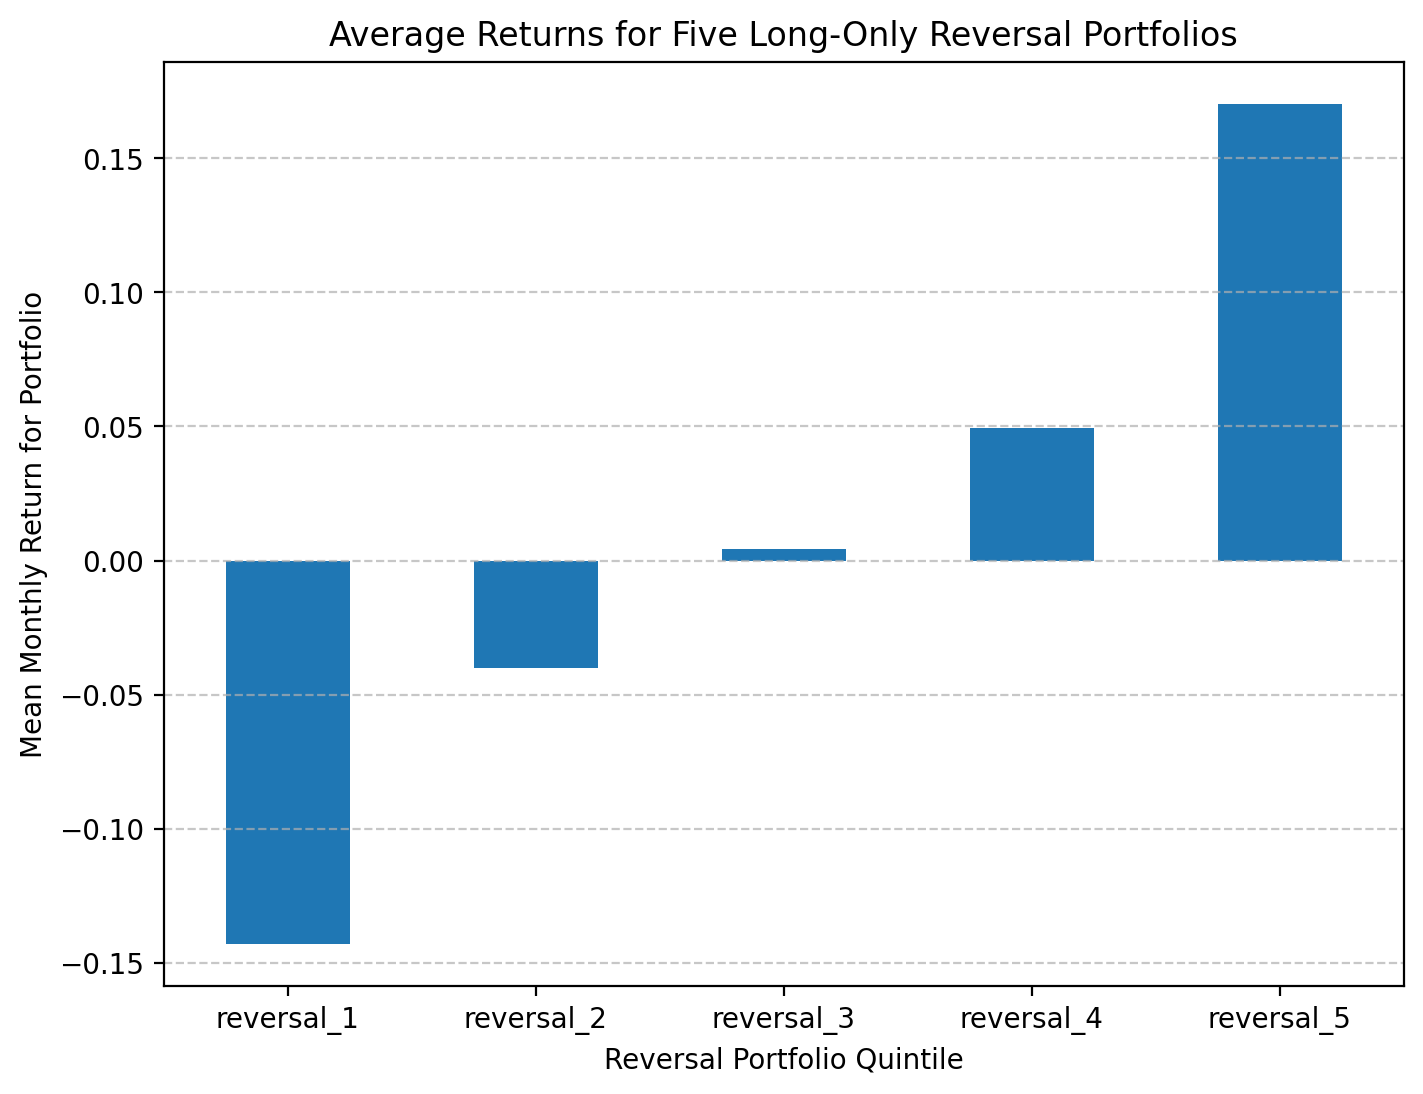

In [16]:
# Create a single plot to show portfolio returns
plt.figure(figsize=(8, 6)) 

# Plot the average returns for the five long-only reversal portfolios
portfolios[['reversal_1', 'reversal_2', 'reversal_3', 'reversal_4', 'reversal_5']].mean().plot(kind='bar')

# Set labels and title
plt.xlabel('Reversal Portfolio Quintile')
plt.ylabel('Mean Monthly Return for Portfolio')
plt.title('Average Returns for Five Long-Only Reversal Portfolios')


# Add a grid and rotate x-axis labels to make readable
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=0) 

plt.show()


The results show that **reversal_1**, which includes stocks with the worst recent performance, has a negative return, while **reversal_5**, which includes stocks with the best recent performance, has a positive return. This means that the worst-performing stocks (reversal_1) haven't bounced back yet, while the top-performing stocks (reversal_5) continue to do well. This pattern is typical in reversal strategies, where stocks that have been doing poorly are expected to improve, and those that have been doing well are expected to keep performing strongly.

#### Question 8 (20 points)

Regress the reversal factor on Fama-French three factors. Report the regression coefficients and p values in a table called `results_ff3`. The table should have intuitive row and column labels. Next, interpret `results_ff3`.
- You need to download the Fama-French three factor returns first
- Note: the reversal factor is already a long-short portfolio, so there's no need to calculate excess returns to estimate factor models.

In [17]:
# Download Fama-French 3-factor data
ff3 = web.DataReader('F-F_Research_Data_Factors', 'famafrench', start='2014-03-31')[0]

# Convert the index from Period to Datetime
ff3.index = ff3.index.to_timestamp() 

# Rename and format columns
ff3 = ff3.rename(columns={'Mkt-RF': 'Mkt_RF', 'SMB': 'SMB', 'HML': 'HML'}) 
ff3 = ff3[['Mkt_RF', 'SMB', 'HML']] / 100


C:\Users\simri\AppData\Local\Temp\ipykernel_24656\4096467673.py:2: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  ff3 = web.DataReader('F-F_Research_Data_Factors', 'famafrench', start='2014-03-31')[0]
C:\Users\simri\AppData\Local\Temp\ipykernel_24656\4096467673.py:2: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  ff3 = web.DataReader('F-F_Research_Data_Factors', 'famafrench', start='2014-03-31')[0]


In [18]:
# Align indices to end-of-month for both DataFrames
portfolios.index = portfolios.index.to_period('M').to_timestamp('M')
ff3.index = ff3.index.to_period('M').to_timestamp('M') 

# Rename index
ff3.index.name = 'DATE'

# Merge only on overlapping dates
merged_data = pd.merge(
    portfolios[['reversal_factor']],
    ff3,
    left_index=True,
    right_index=True,
    how='inner'
)

# Drop missing values
merged_data = merged_data.dropna()


In [19]:
# Define dependent (Y) and independent (X) variables and add constant
Y = merged_data['reversal_factor']  
X = merged_data[['Mkt_RF', 'SMB', 'HML']]  
X = sm.add_constant(X)  

# Fit the regression model
model = sm.OLS(Y, X).fit()

In [20]:
# Show results
results_ff3 = pd.DataFrame({
    'Factors': ['Intercept', 'Mkt_RF', 'SMB', 'HML'],
    'Coefficients': model.params.values,
    'P-Values': model.pvalues.values
})

print(results_ff3)

     Factors  Coefficients      P-Values
0  Intercept      0.313792  1.065060e-83
1     Mkt_RF      0.043440  7.369945e-01
2        SMB      0.618331  4.438475e-03
3        HML      0.144186  3.368588e-01


In [21]:
# Evaluation cell (do not change)
print('Code: 10 points; Interpretation: 10 points')
print(results_ff3.describe())

Code: 10 points; Interpretation: 10 points
       Coefficients      P-Values
count      4.000000  4.000000e+00
mean       0.279937  2.695729e-01
std        0.251671  3.492736e-01
min        0.043440  1.065060e-83
25%        0.119000  3.328856e-03
50%        0.228989  1.706486e-01
75%        0.389926  4.368927e-01
max        0.618331  7.369945e-01


The regression results show that the reversal strategy has a strong **Intercept** (0.3138, p-value < 0.0001), meaning it generates positive returns that are not explained by the Fama-French factors. The **Mkt_RF** factor (0.0434, p-value = 0.737) has a very small and insignificant effect, so the strategy is not strongly linked to overall market movements. The **SMB** factor (0.6183, p-value = 0.0044) is large and significant, meaning that the strategy performs well with small-cap stocks. The **HML** factor (0.1442, p-value = 0.337) has a weak and insignificant effect, so there isn’t a clear connection to value stocks. Overall, the strategy’s success comes mostly from its  small-cap stocks, while the market and value factors don’t have much impact.

Looking at the summary statistics for the coefficients and p-values, the average coefficient across all factors is 0.2799, with a wide range from 0.0434 to 0.6183, suggesting that some factors (like SMB) are much stronger than others (like Mkt_RF). The p-values vary a lot, with a mean of 0.2696 and a standard deviation of 0.3493, highlighting that only certain factors (like SMB) are statistically significant, while others (like Mkt_RF and HML) are not. This supports the idea that small-cap stocks drives the reversal strategy’s performance, with other factors having little to no impact.